In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

binom = np.random.binomial

In [ ]:
a = np.zeros((10,20))
np.sum(a,axis=1)

In [105]:
class HebbianLearning:
    # Implements a set of neurons whose weights update by Hebb's rule
    
    def __init__(self, N=18, nLGN=4, nGroups=6, alpha=.01):
        self.N = N # number of V1 neurons
        self.alpha = alpha # learning rate
        self.nLGN = nLGN # number of LGN neurons
        self.nGroups = nGroups # number of groups of V1 neurons (must evenly divide self.N)
        self.nPerGroup = self.N / self.nGroups # number of v1 neurons per group
        
        self.groups = np.reshape(np.array(range(self.N)), (self.nGroups, self.nPerGroup))
        
        # Create N=ten neurons that initially fire randomly (N-length vector of 1s and 0s)
        self.spikes = {}
        self.probs = {}
        self.inhibitConns = {}
        self.excitConns = {}
        
        # Initialize a NxN weight matrix where element ij is the weight between neurons i and j.
        self.v1_weights = np.zeros((self.N, self.N)) # matrix of weights between v1 neurons
        self.v1_LGN_weights = np.zeros((self.N, self.nLGN)) # matrix of weights between v1 and lgn neurons
        self.initWeightMatrix()
        
        
    
    def initWeightMatrix(self):
        
        # First assign each neuron an inhibitory neuron from every other group.
        for i in range(self.N):
            self.inhibitConns[i] = np.array([])
            for g in range(self.nGroups):
                if i not in self.groups[g]:
                    self.inhibitConns[i] = np.append(self.inhibitConns[i], np.random.choice(self.groups[g]))        
        
        # Next assign each neuron its group members as excitatory neurons
        for g in range(self.nGroups):
            for n in range(self.nPerGroup):
                self.excitConns[self.groups[g,n]] = self.groups[g]
        
        # Then initialize weight matrix
        for i in range(self.N):
            for j in range(self.N):
                if i < j:
                    if np.where(self.groups == i)[0] == np.where(self.groups == j)[0]: # if neurons are in same group
                        self.v1_weights[i,j] = .25  + (.05*np.random.rand()) #+.5*np.random.rand() # weak excitatory
                    elif j in self.inhibitConns[i]: # if neurons are inhibitory to each other.
                        self.v1_weights[i,j] = -.25 + (.05*np.random.rand())#-.1*np.random.rand() # weak inhibitory
                if j < i:
                    self.v1_weights[i,j] = self.v1_weights[j,i]

        # V1<--->LGN connections are random from -1 to 1
        self.v1_LGN_weights = np.random.choice([-1, -.5, 0, .1], size=(self.N, self.nLGN))
        
        for g in range(self.nGroups):
            ldr = np.random.choice(self.groups[g])
            self.v1_LGN_weights[ldr,g%self.nLGN] = 0.75 + np.random.rand()*.05
            self.v1_LGN_weights[np.setdiff1d(self.groups[g], ldr), g%self.nLGN] = np.random.rand()*.05 - .025
            
    
    def train(self, N_ITERS=1000, fig=None):
        for i in range(N_ITERS):
            # First, generate a new observation for the next training step
            obs_v1, obs_lgn = self.generate_training_sample()
            
            for vi in range(self.N):
                for v2i in range(self.N):
                    if vi<v2i and (v2i in self.excitConns[vi]) and obs_v1[vi] == obs_v1[v2i] and obs_v1[vi] == 1: # if they fire together
                        if np.random.rand() < .5: # subject only updates 1/2 the times that neurons fire together
                            self.v1_weights[vi, v2i] = self.v1_weights[vi,v2i] + self.alpha
                    elif vi<v2i and (v2i in self.inhibitConns[vi] or v2i in self.excitConns[vi]): # if they dont fire together
                        if np.random.rand() < .10:
                            self.v1_weights[vi, v2i] = self.v1_weights[vi,v2i] - self.alpha
                    elif vi>=v2i:
                        self.v1_weights[vi,v2i] = self.v1_weights[v2i,vi]
                
                for li in range(self.nLGN):
                    if obs_v1[vi] == obs_lgn[li] and obs_v1[vi] == 1:
                        if np.random.rand() < .5:
                            self.v1_LGN_weights[vi, li] = self.v1_LGN_weights[vi,li] + self.alpha
                    else:
                        if np.random.rand() < .10:
                            self.v1_LGN_weights[vi, li] = self.v1_LGN_weights[vi,li] - self.alpha


    def generate_training_sample(self):
        lgn_spikes, lgn_probs = self.sample_from_LGN()
    
        # Multiply LGN weights by LGN firing rate to get initial 
        lgn_influence = np.matmul(self.v1_LGN_weights, lgn_probs)
        #v1_influence = np.matmul(self.v1_weights, self.probs[len(self.probs)-1])
        v1_influence = np.matmul(self.v1_weights, lgn_influence)
        
        v1_probs = 1.0*(lgn_influence  + v1_influence)
        #v1_probs = (lgn_influence + v1_influence) / (self.N + self.nLGN)*1.0
        #v1_probs = v1_influence
        train_samp = np.random.rand(len(v1_probs)) < v1_probs #binom(n=1, p = np.maximum(v1_probs,0))
        
        
        self.spikes[len(self.spikes)] = train_samp
        self.probs[len(self.probs)] = v1_probs
        
        return train_samp, lgn_spikes
    
    def sample_from_LGN(self):
        # Pick an orientation and set LGN firing probabilities accordingly.
        ori = np.random.randint(0,self.nLGN)
        lgn_probs = np.zeros((self.nLGN,))
        lgn_probs[ori] = 1.0; lgn_probs[(ori+1)%self.nLGN] = 0; lgn_probs[(ori-1)%self.nLGN] = 0;
        lgn_spikes = np.random.rand(self.nLGN) < lgn_probs 
        
        return lgn_spikes, lgn_probs        

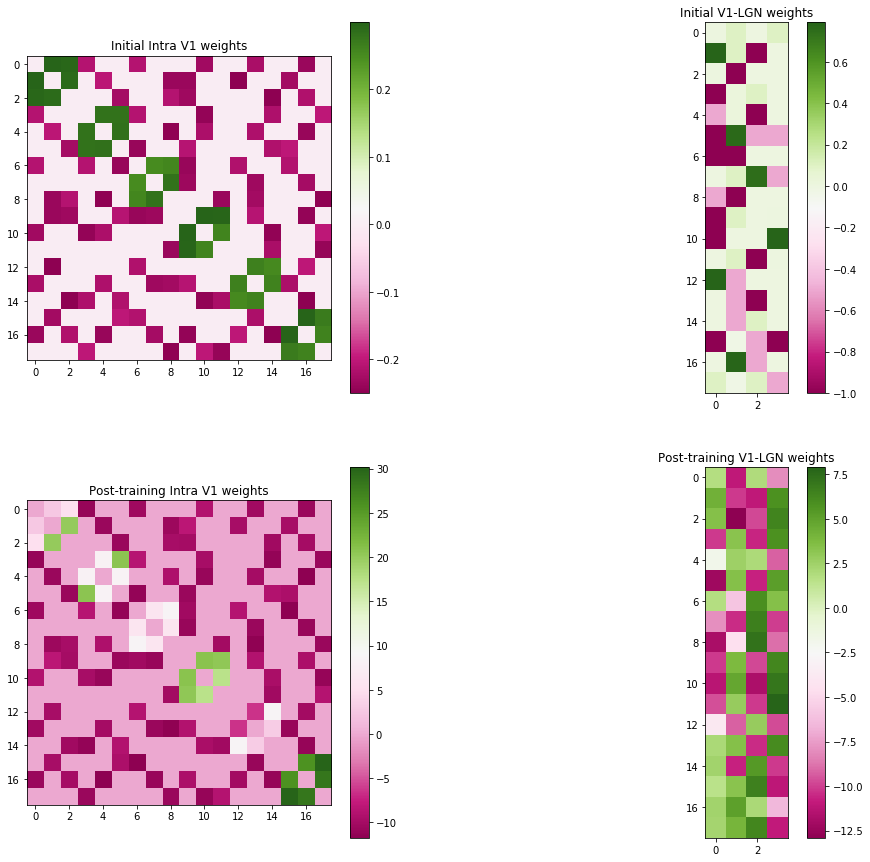

In [106]:
HL = HebbianLearning(alpha=.1)
pre = HL.v1_weights

fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(1.0*pre, cmap='PiYG')
plt.title('Initial Intra V1 weights')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(1.0*HL.v1_LGN_weights, cmap='PiYG')
plt.title('Initial V1-LGN weights')
plt.colorbar()

HL.train(N_ITERS=1000)

#v1_weights = 1.0*HL.v1_weights / (np.max(HL.v1_weights) - np.min(HL.v1_weights))
#v1_LGN_weights = 1.0*HL.v1_LGN_weights / (np.max(HL.v1_LGN_weights) - np.min(HL.v1_LGN_weights))

#v1_weights = 1.0*HL.v1_weights / (np.linalg.norm(HL.v1_weights))
#v1_LGN_weights = 1.0*HL.v1_LGN_weights / (np.linalg.norm(HL.v1_LGN_weights))

plt.subplot(2,2,3)
plt.imshow(HL.v1_weights, cmap='PiYG')
plt.title('Post-training Intra V1 weights')
plt.colorbar()

plt.subplot(2,2,4)
ax = plt.imshow(HL.v1_LGN_weights, cmap='PiYG')
plt.title('Post-training V1-LGN weights')
plt.colorbar()
